# Evaluating Experiment for Stock Price Movements

> We can evaluate the movement for all data set

## Import Librarys

In [1]:
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd

## Load Dataset

In [21]:
df = pd.read_csv("./stock-price-prediction/MSFT.csv")

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,58.68750,59.3125,56.00000,58.28125,37.199776,53228400
1,2000-01-04,56.78125,58.5625,56.12500,56.31250,35.943153,54119000
2,2000-01-05,55.56250,58.1875,54.68750,56.90625,36.322121,64059600
3,2000-01-06,56.09375,56.9375,54.18750,55.00000,35.105415,54976600
4,2000-01-07,54.31250,56.1250,53.65625,55.71875,35.564171,62013600


## Preprocessing

In [22]:
# specifie the same variable used during train
data_split = int(df.shape[0]*0.8)
data_set = df.iloc[:, 3:4].values
training_set = data_set[:data_split,:]
test_set = data_set[data_split:, :]

In [23]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0, 1))
data_set_scaled = sc.fit_transform(data_set)
training_set_scaled = data_set_scaled[:data_split]
print(training_set_scaled.shape)
test_set_scaled = data_set_scaled[data_split:]
print(test_set_scaled.shape)

(4173, 1)
(1044, 1)


In [24]:
X_train = []
y_train = []
X_test = []
y_test = []

for i in range(30, training_set.shape[0]):
    X_train.append(training_set_scaled[i-30:i, 0])
    y_train.append(training_set_scaled[i, 0])

for i in range(30, test_set.shape[0]):
    X_test.append(test_set_scaled[i-30:i, 0])
    y_test.append(test_set_scaled[i, 0])


X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    
    
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(4143, 30, 1) (4143,) (1014, 30, 1) (1014,)


## Load Model

In [25]:
model = load_model("model.h5")

In [26]:
trainPredict = model.predict(X_train[:X_train.shape[0]*80//100])
valPredict = model.predict(X_train[X_train.shape[0]*80//100:])
testPredict = model.predict(X_test)

trainPredict = np.c_[trainPredict, np.zeros(trainPredict.shape)]
valPredict = np.c_[valPredict, np.zeros(valPredict.shape)]
testPredict = np.c_[testPredict, np.zeros(testPredict.shape)]

In [27]:
# invert predictions

trainPredict = sc.inverse_transform(trainPredict)
trainPredict = [x[0] for x in trainPredict]

valPredict = sc.inverse_transform(valPredict)
valPredict = [x[0] for x in valPredict]


testPredict = sc.inverse_transform(testPredict)
testPredict = [x[0] for x in testPredict]

## Evaluation

## RMSE Metric

In [28]:
# calculate the root_mean_squared_error

trainScore = mean_squared_error([x[0][0] for x in X_train[:X_train.shape[0]*80//100]],
                                trainPredict, squared=False)

print("Train Score: {:.2f} RMSE".format(trainScore))


valScore = mean_squared_error([x[0][0] for x in X_train[X_train.shape[0]*80//100:]],
                              valPredict, squared=False)

print("Val Score: {:.2f} RMSE".format(valScore))

testScore = mean_squared_error([x[0][0] for x in X_test], testPredict, squared=False)

print("Test Score: {:.2f} RSME".format(testScore))

Train Score: 27.89 RMSE
Val Score: 42.42 RMSE
Test Score: 102.92 RSME


### Visualizing the Stock Price Movement

(5217, 1) (4328,) (3314,) (1014,)


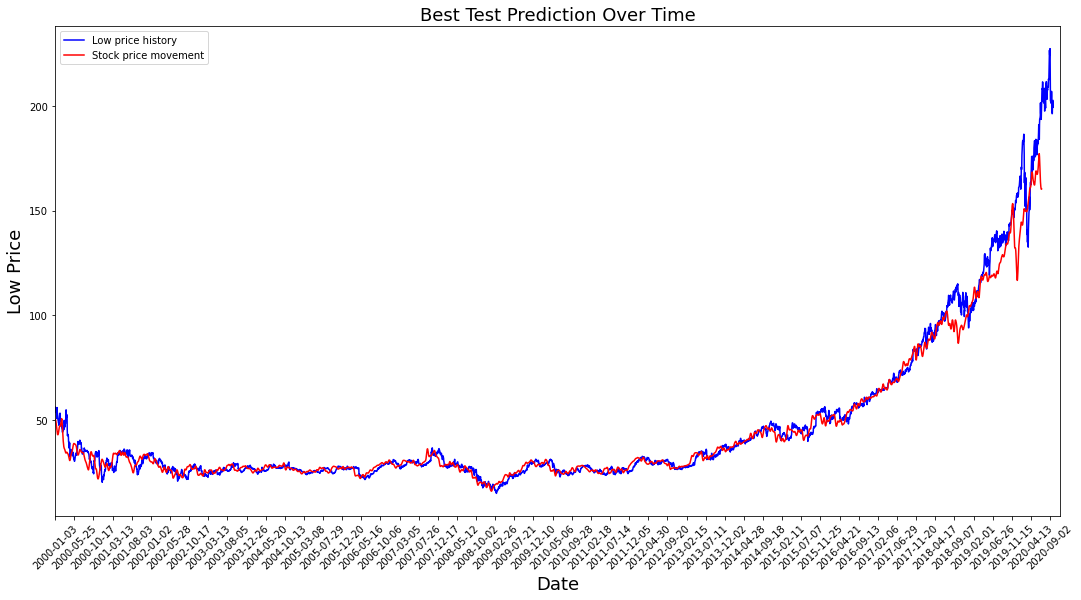

In [33]:
data_set_predicted = np.concatenate((trainPredict,valPredict, testPredict), axis=0)

plt.figure(figsize=(18, 9))

plt.plot(range(df.shape[0]), data_set, color='b', label='Low price history')

trainPredict, testPredict = np.array(trainPredict), np.array(testPredict)

print(data_set.shape, np.concatenate((trainPredict, testPredict), axis=0).shape, trainPredict.shape, testPredict.shape)
plt.plot(range(data_set_predicted.shape[0]), data_set_predicted, color='r', label='Stock price movement')

plt.legend()
plt.title("Best Test Prediction Over Time", fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Low Price", fontsize=18)
plt.xticks(range(0, df.shape[0], 100), df["Date"].loc[::100], rotation=45)
plt.xlim(0, 5250)
plt.savefig("result.png")